## **More advanced EDA** ⚙️

Let's apply some more advanced EDA techniques. First, let's handle the data imputation part.

In [3]:
import pandas as pd

# Dataset loading
data = pd.read_csv(r'C:\Users\rejen\OneDrive\Documents\GitHub\ProjektAnalitiks\data\03_Processed\cleaned_data.csv')
df = pd.read_csv(r'C:\Users\rejen\OneDrive\Documents\GitHub\ProjektAnalitiks\data\03_Processed\cleaned_data.csv')

In [4]:
from sklearn.impute import KNNImputer
import pandas as pd

# Loading data
file_path = r'C:\Users\rejen\OneDrive\Documents\GitHub\ProjektAnalitiks\data\03_Processed\cleaned_data.csv'
data = pd.read_csv(file_path)

# Initializing the KNN imputer
imputer = KNNImputer(n_neighbors=5)

# Applying the imputer to the numerical columns
numerical_data = data.select_dtypes(include=['float64', 'int64'])

# Handling columns with all missing values
columns_with_all_missing = numerical_data.columns[numerical_data.isnull().all()].tolist()
numerical_data = numerical_data.drop(columns=columns_with_all_missing)

imputed_data = pd.DataFrame(imputer.fit_transform(numerical_data), columns=numerical_data.columns)

# Combining imputed numerical data with non-numerical data
data_imputed = data.copy()
data_imputed[numerical_data.columns] = imputed_data

# Re-adding columns that had all missing values, if necessary
for col in columns_with_all_missing:
    data_imputed[col] = data[col]

# Exporting the dataset to the same folder
output_path = r'C:\Users\rejen\OneDrive\Documents\GitHub\ProjektAnalitiks\data\02_Interim\dropped_rows_columns_imputed.csv'
data_imputed.to_csv(output_path, index=False)

print(f"Dataset saved to {output_path}")

Dataset saved to C:\Users\rejen\OneDrive\Documents\GitHub\ProjektAnalitiks\data\02_Interim\dropped_rows_columns_imputed.csv


##### Now let's check correlations between different numerical values respesenting competency areas by using correlation matrix.

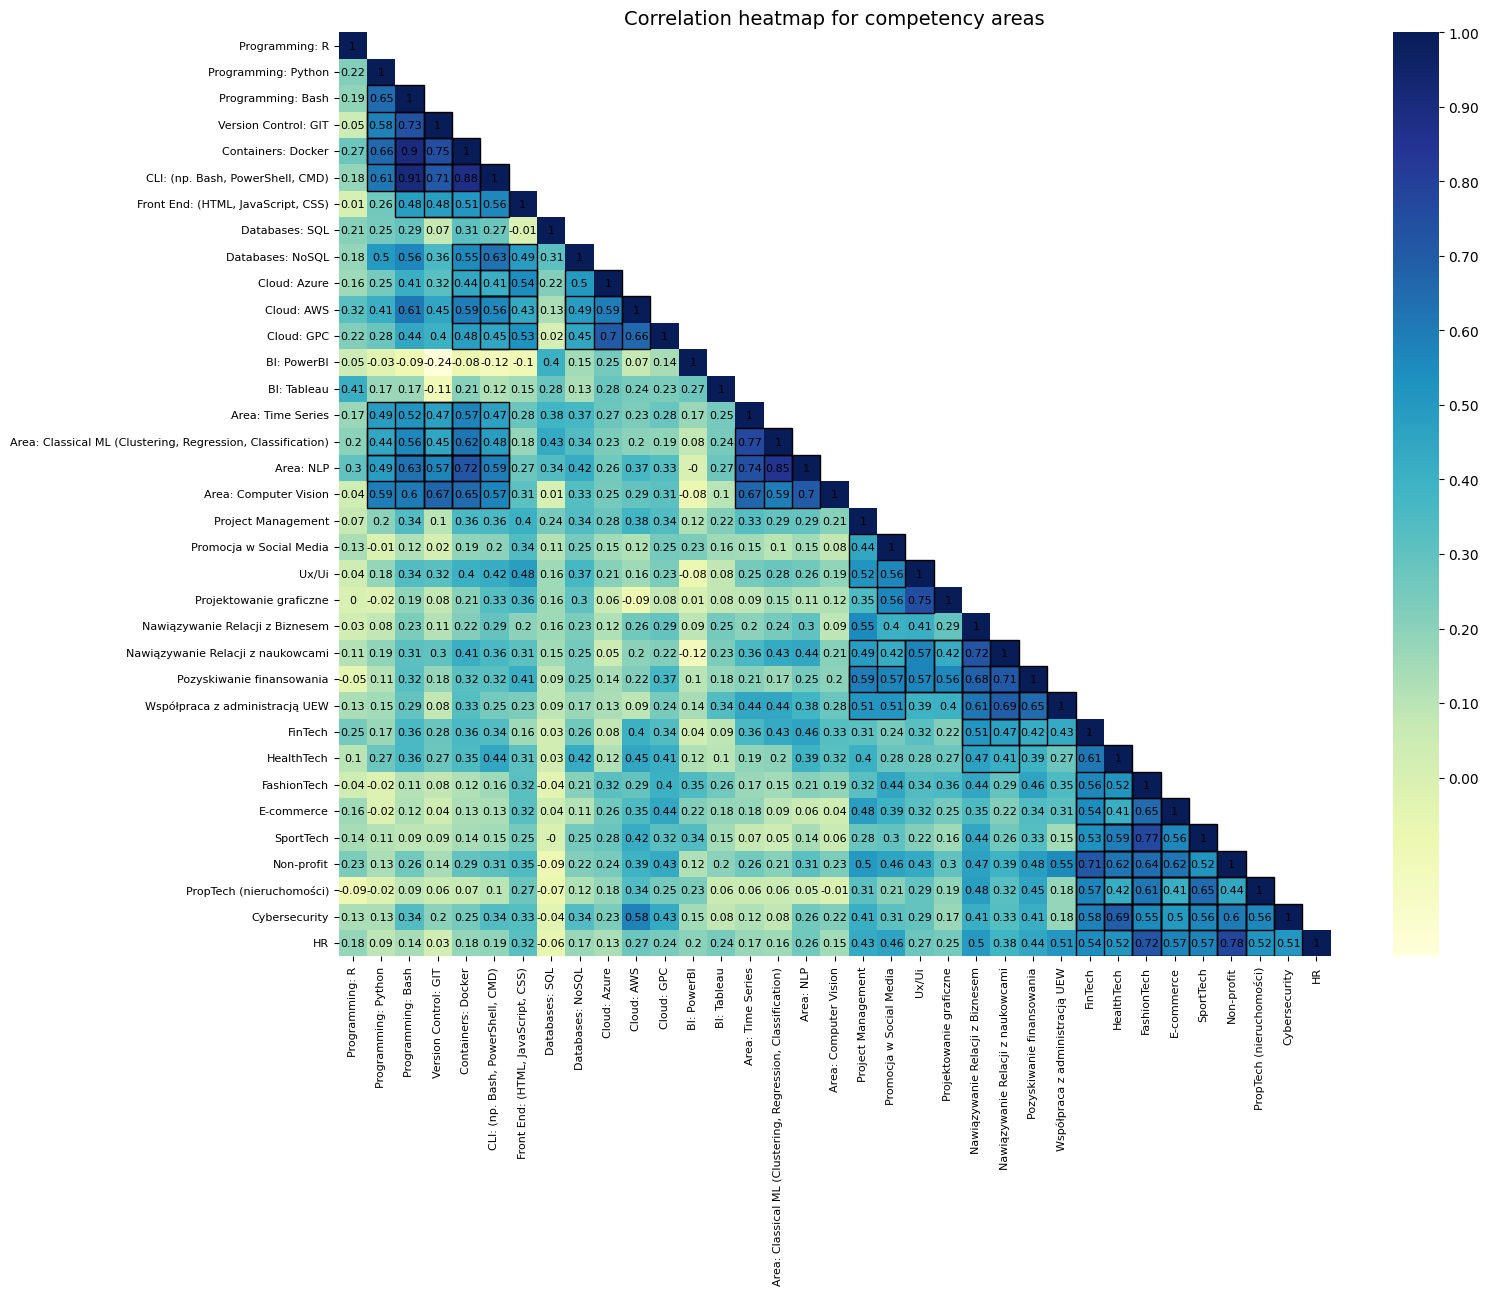

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Dataset loading
data = pd.read_csv(r'C:\Users\rejen\OneDrive\Documents\GitHub\ProjektAnalitiks\data\03_Processed\cleaned_data.csv')

# Dropping the "ID" column if it exists
if 'ID' in data.columns:
    data = data.drop(columns=['ID'])

# Calculating the correlation matrix and rounding to two decimal places
correlation_matrix = data.corr(numeric_only=True).round(2)

# Custom formatter function to remove trailing zeros
def custom_formatter(x):
    if pd.isna(x):
        return ""
    return ('%.2f' % x).rstrip('0').rstrip('.')

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Setting background color to white
plt.figure(figsize=(16, 12), facecolor='white')
ax = plt.gca()
ax.set_facecolor('white')

# Plotting correlation heatmap without annotations and with a mask
heatmap = sns.heatmap(correlation_matrix, mask=mask, cmap="YlGnBu", linewidths=0, linecolor='white', annot=False, cbar_kws={'format': '%.2f', 'ticks': np.linspace(0, 1, 11)}, ax=ax)

# Manually adding annotations with custom formatting to the lower triangle and diagonal only
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i >= j:  # Only annotate the lower triangle and diagonal
            text = custom_formatter(correlation_matrix.iloc[i, j])
            heatmap.text(j + 0.5, i + 0.5, text,
                         ha='center', va='center', color='black', fontsize=8)

# Function to add a thick border around a cluster
def add_thick_border(heatmap, cluster_cells, color='black', linewidth=1):
    min_i = min(cell[0] for cell in cluster_cells)
    max_i = max(cell[0] for cell in cluster_cells)
    min_j = min(cell[1] for cell in cluster_cells)
    max_j = max(cell[1] for cell in cluster_cells)
    heatmap.add_patch(plt.Rectangle((min_j, min_i), max_j - min_j + 1, max_i - min_i + 1, fill=False, edgecolor=color, lw=linewidth))

# Finding clusters and drawing thick borders around them
for i in range(correlation_matrix.shape[0] - 1):
    for j in range(i):
        if correlation_matrix.iloc[i, j] > 0.4:
            cluster_cells = [(i, j)]
            if (correlation_matrix.iloc[i + 1, j] > 0.4 and
                correlation_matrix.iloc[i, j + 1] > 0.4 and
                correlation_matrix.iloc[i + 1, j + 1] > 0.4):
                cluster_cells.append((i + 1, j))
                cluster_cells.append((i, j + 1))
                cluster_cells.append((i + 1, j + 1))
                add_thick_border(heatmap, cluster_cells)

plt.title("Correlation heatmap for competency areas", fontsize=14, color='black')
plt.xticks(fontsize=8, rotation=90, color='black')
plt.yticks(fontsize=8, rotation=0, color='black')

# Setting the legend text color to black
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.set_tick_params(color='black')
plt.setp(plt.getp(colorbar.ax.axes, 'yticklabels'), color='black')

plt.show()

According to the heatmap above, we see some remarkable clusters near the diagonal axis. 
- The most visible one contains of **programming stack**: Python, CLI, Bash, Git and Docker.

- The second cluster is all **Cloud** - GCP, Azure, AWS with addition of NoSQL databases.

- Third noticable cluster is connected strictly to **Data Science** - ML, NLP, Computer Vision, time series.

- Fourth cluster has **soft skills** in it and fifth has **types of industries**.

We can also observe that we don't have any negatively correlated clusters nor values.

It is time to use hierarchical clustering. To be assured of it's best results, I will apply **elbow method** to ensure about the best k-value. I will try two approaches to see which one is more accurate.

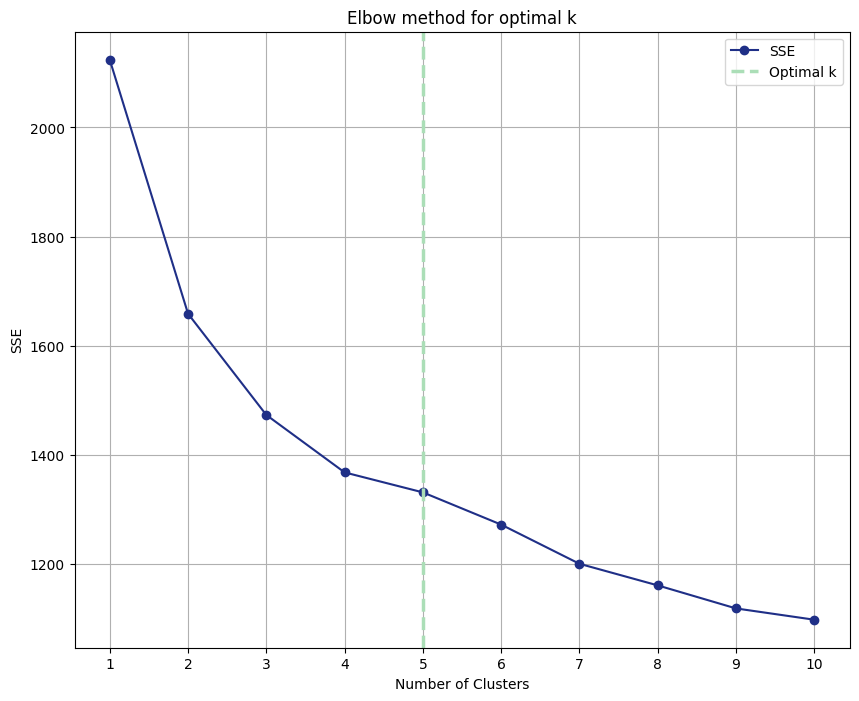

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load the dataset
file_path = r'C:\Users\rejen\OneDrive\Documents\GitHub\ProjektAnalitiks\data\03_Processed\cleaned_data.csv'
data = pd.read_csv(file_path)

# Dropping non-numeric columns for clustering
numeric_data = data.select_dtypes(include=[np.number])

# Standardizing the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Determine the optimal number of clusters using the elbow method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

# Creating a custom YlGnBu colormap
ylgnbu = plt.get_cmap('YlGnBu')

# Plotting the elbow method results with the requested colors
plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), sse, marker='o', color=ylgnbu(0.9), label='SSE')  # Dark blue line
plt.title('Elbow method for optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.xticks(range(1, 11))
plt.grid(True)

# Marking the elbow point
optimal_k = np.diff(sse, 2).argmin() + 2  # Adding 2 because np.diff reduces the original array size by 2
plt.axvline(x=optimal_k, color=ylgnbu(0.3), linestyle='--', linewidth=2.5, label='Optimal k')  # Bolder vertical line

plt.legend()
plt.show()

According to Sum of Squared Errors method we should take k = 4. Let's visualize the data using dendrogram with four clusters.

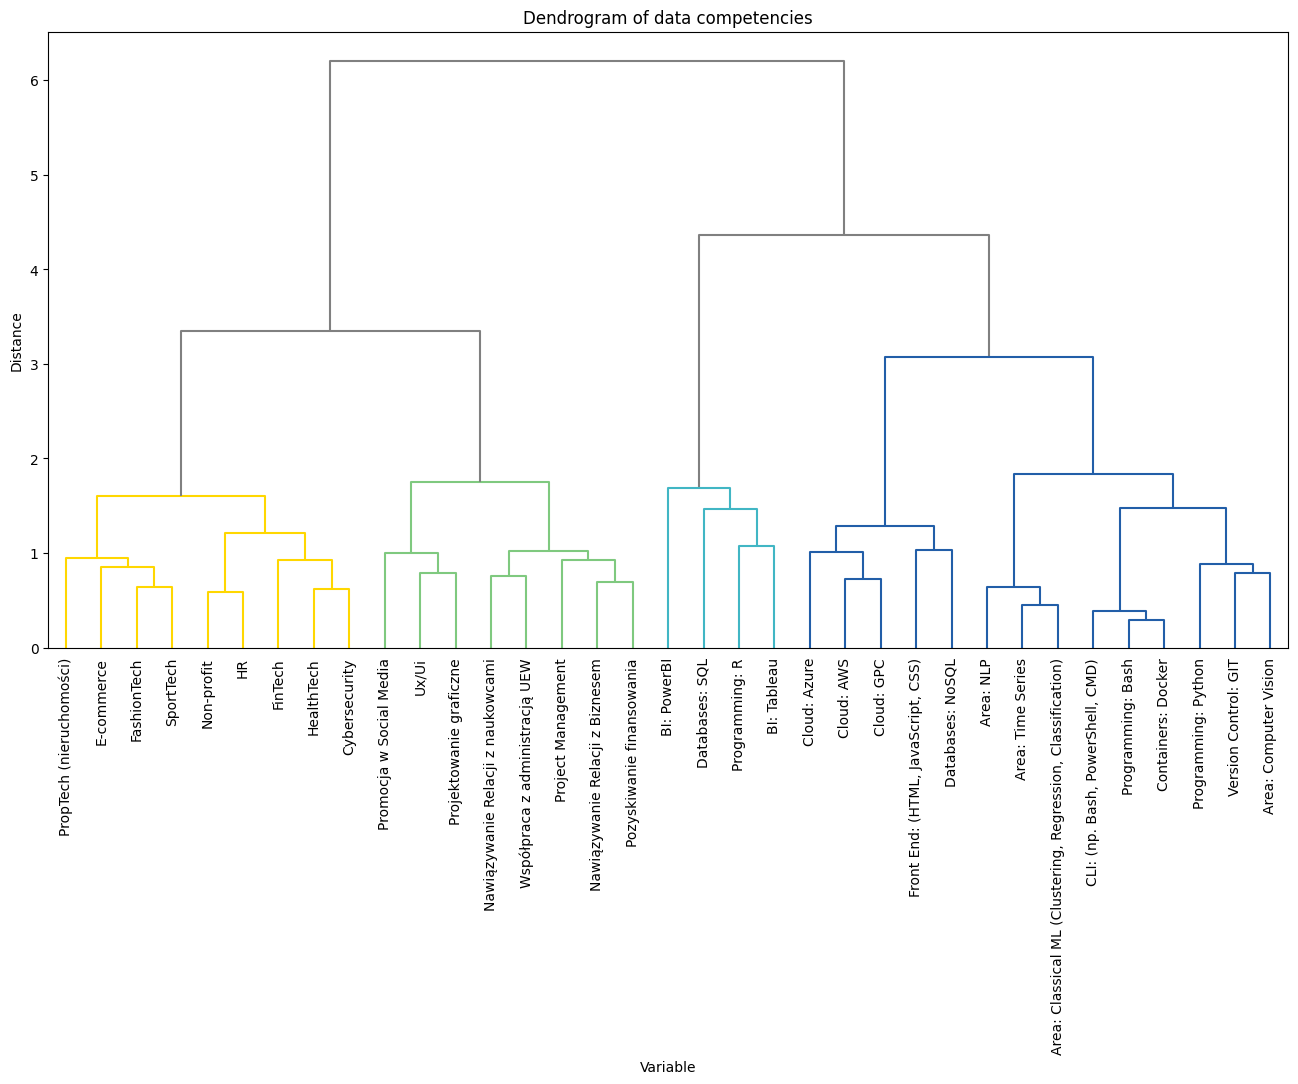

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Assuming `data` is the DataFrame that contains your dataset.
# Excluding the 'ID' and 'Group' columns from the correlation matrix
correlation_matrix = data.drop(columns=['ID']).corr(numeric_only=True)

# Calculating the linkage matrix using Ward's method
linkage_matrix = linkage(correlation_matrix, method='ward')

color_palette = ['#FFD700', '#7FC97F', '#41B6C4', '#225EA8']  # Yellow-Orange, Contrasty Green, Light Blue, Dark Blue

# Extracting cluster labels for each variable
k = 4  # Number of clusters
cluster_labels = fcluster(linkage_matrix, k, criterion='maxclust')

# Creating a dictionary to map each variable to its cluster color
leaf_colors = {correlation_matrix.columns[i]: color_palette[cluster_labels[i] - 1] for i in range(len(correlation_matrix.columns))}

# Color mapping
dflt_col = "#808080"  # Unclustered gray
link_cols = {}

# Determine the colors for the links
for i, i12 in enumerate(linkage_matrix[:, :2].astype(int)):
    c1, c2 = (link_cols[x] if x > len(linkage_matrix) else leaf_colors[correlation_matrix.columns[x]]
              for x in i12)
    link_cols[i + 1 + len(linkage_matrix)] = c1 if c1 == c2 else dflt_col

# Plotting dendrogram to identify clusters
plt.figure(figsize=(16, 8))
dendro = dendrogram(
    linkage_matrix,
    labels=correlation_matrix.columns,
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=None,
    link_color_func=lambda x: link_cols[x]
)

# Setting the labels to black
for label in plt.gca().get_xticklabels():
    label.set_color('black')

plt.title("Dendrogram of data competencies")
plt.xlabel("Variable")
plt.ylabel("Distance")
plt.show()

# Combining cluster labels with the correlation matrix
clustered_data = pd.DataFrame({
    'Variable': correlation_matrix.columns,
    'Cluster': cluster_labels
})

# Sorting variables by cluster
clustered_data = clustered_data.sort_values(by='Cluster').reset_index(drop=True)


Based on dendrogram above we can see that on we have a cluster with skills mostly considered as <font color='green'>**soft skills**</font> with some exceptions like UX/UI and Graphics Design, that could be technical skills. On the left side with yellow color we can see <font color='yellow'>**industry**</font> skills.

On the right side from the middle there is a cluster with <font color='navy'>**hard skills**</font>. Green graph, representing <font color='teal'>**popular data skills**</font> could be assigned to red as well to match other technical skills. The smaller branch of blue graph clustered technical skills.

Now let's visualize how the answer values distribute over all columns and sort them descendingly.

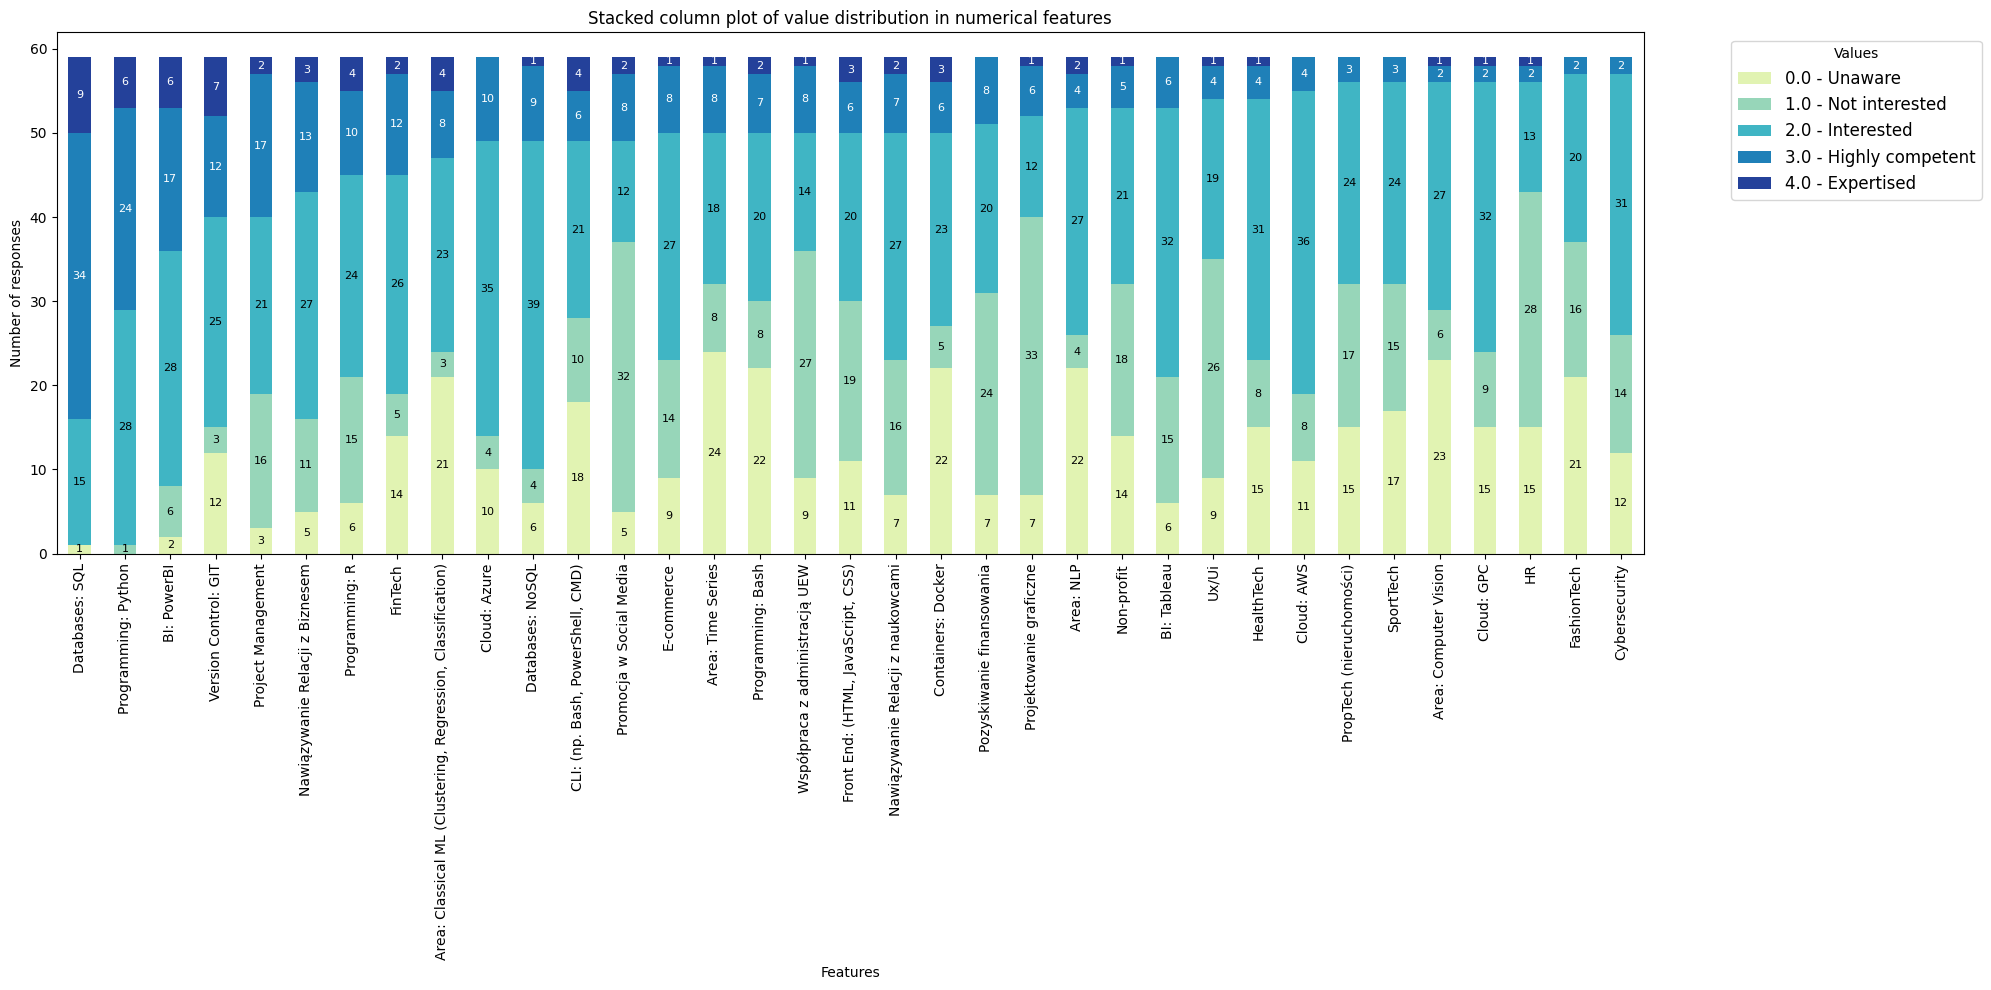

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset loading
data = pd.read_csv(r'C:\Users\rejen\OneDrive\Documents\GitHub\ProjektAnalitiks\data\03_Processed\cleaned_data.csv')

# Identify numerical columns excluding "ID"
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.drop('ID')

# Initialize a DataFrame to store the value counts
value_counts = pd.DataFrame(index=[0.0, 1.0, 2.0, 3.0, 4.0])

# Count the occurrences of each value in each numerical column
for column in numeric_columns:
    counts = data[column].value_counts().sort_index()
    value_counts[column] = counts

# Fill NaN values with 0 (for values that do not appear in a column)
value_counts = value_counts.fillna(0)

# Calculate the combined count of 4.0 and 3.0 responses
value_counts.loc['combined'] = value_counts.loc[4.0] + value_counts.loc[3.0]

# Sort the columns based on the combined count of 4.0 and 3.0 responses in descending order
value_counts = value_counts.T.sort_values(by='combined', ascending=False).T
value_counts = value_counts.drop('combined')

# Custom colors for the plot using a more contrasting palette
contrast_colors = sns.color_palette("YlGnBu", n_colors=5).as_hex()
custom_colors = {
    0.0: contrast_colors[0],
    1.0: contrast_colors[1],
    2.0: contrast_colors[2],
    3.0: contrast_colors[3],
    4.0: contrast_colors[4]
}

# Plotting stacked column plot
ax = value_counts.T.plot(kind='bar', stacked=True, figsize=(20, 10), color=[custom_colors[x] for x in value_counts.index])

# Add counts on top of each bar
for container in ax.containers:
    for rect in container:
        height = rect.get_height()
        if height > 0:
            color = rect.get_facecolor()
            luminance = 0.299 * color[0] + 0.587 * color[1] + 0.114 * color[2]
            text_color = 'white' if luminance < 0.5 else 'black'
            ax.text(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2,
                    f'{int(height)}', ha='center', va='center', color=text_color, fontsize=8)

# Titles and labels
plt.title('Stacked column plot of value distribution in numerical features')
plt.xlabel('Features')
plt.ylabel('Number of responses')

# Adjust the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, [
    '0.0 - Unaware',
    '1.0 - Not interested',
    '2.0 - Interested',
    '3.0 - Highly competent',
    '4.0 - Expertised'
], title='Values', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large')

plt.tight_layout()
plt.show()


As observed, we can confirm a strong representation of candidates in data skills such as: **Python**, **SQL/NoSQL** and **PowerBI**. 

This could lead to a conclusion to focus on building teams with both technical proficiency and data visualisation skills.

##### Now let's try to showcase the most correlated pairs of values on a scatter plot and perform regression analysis.

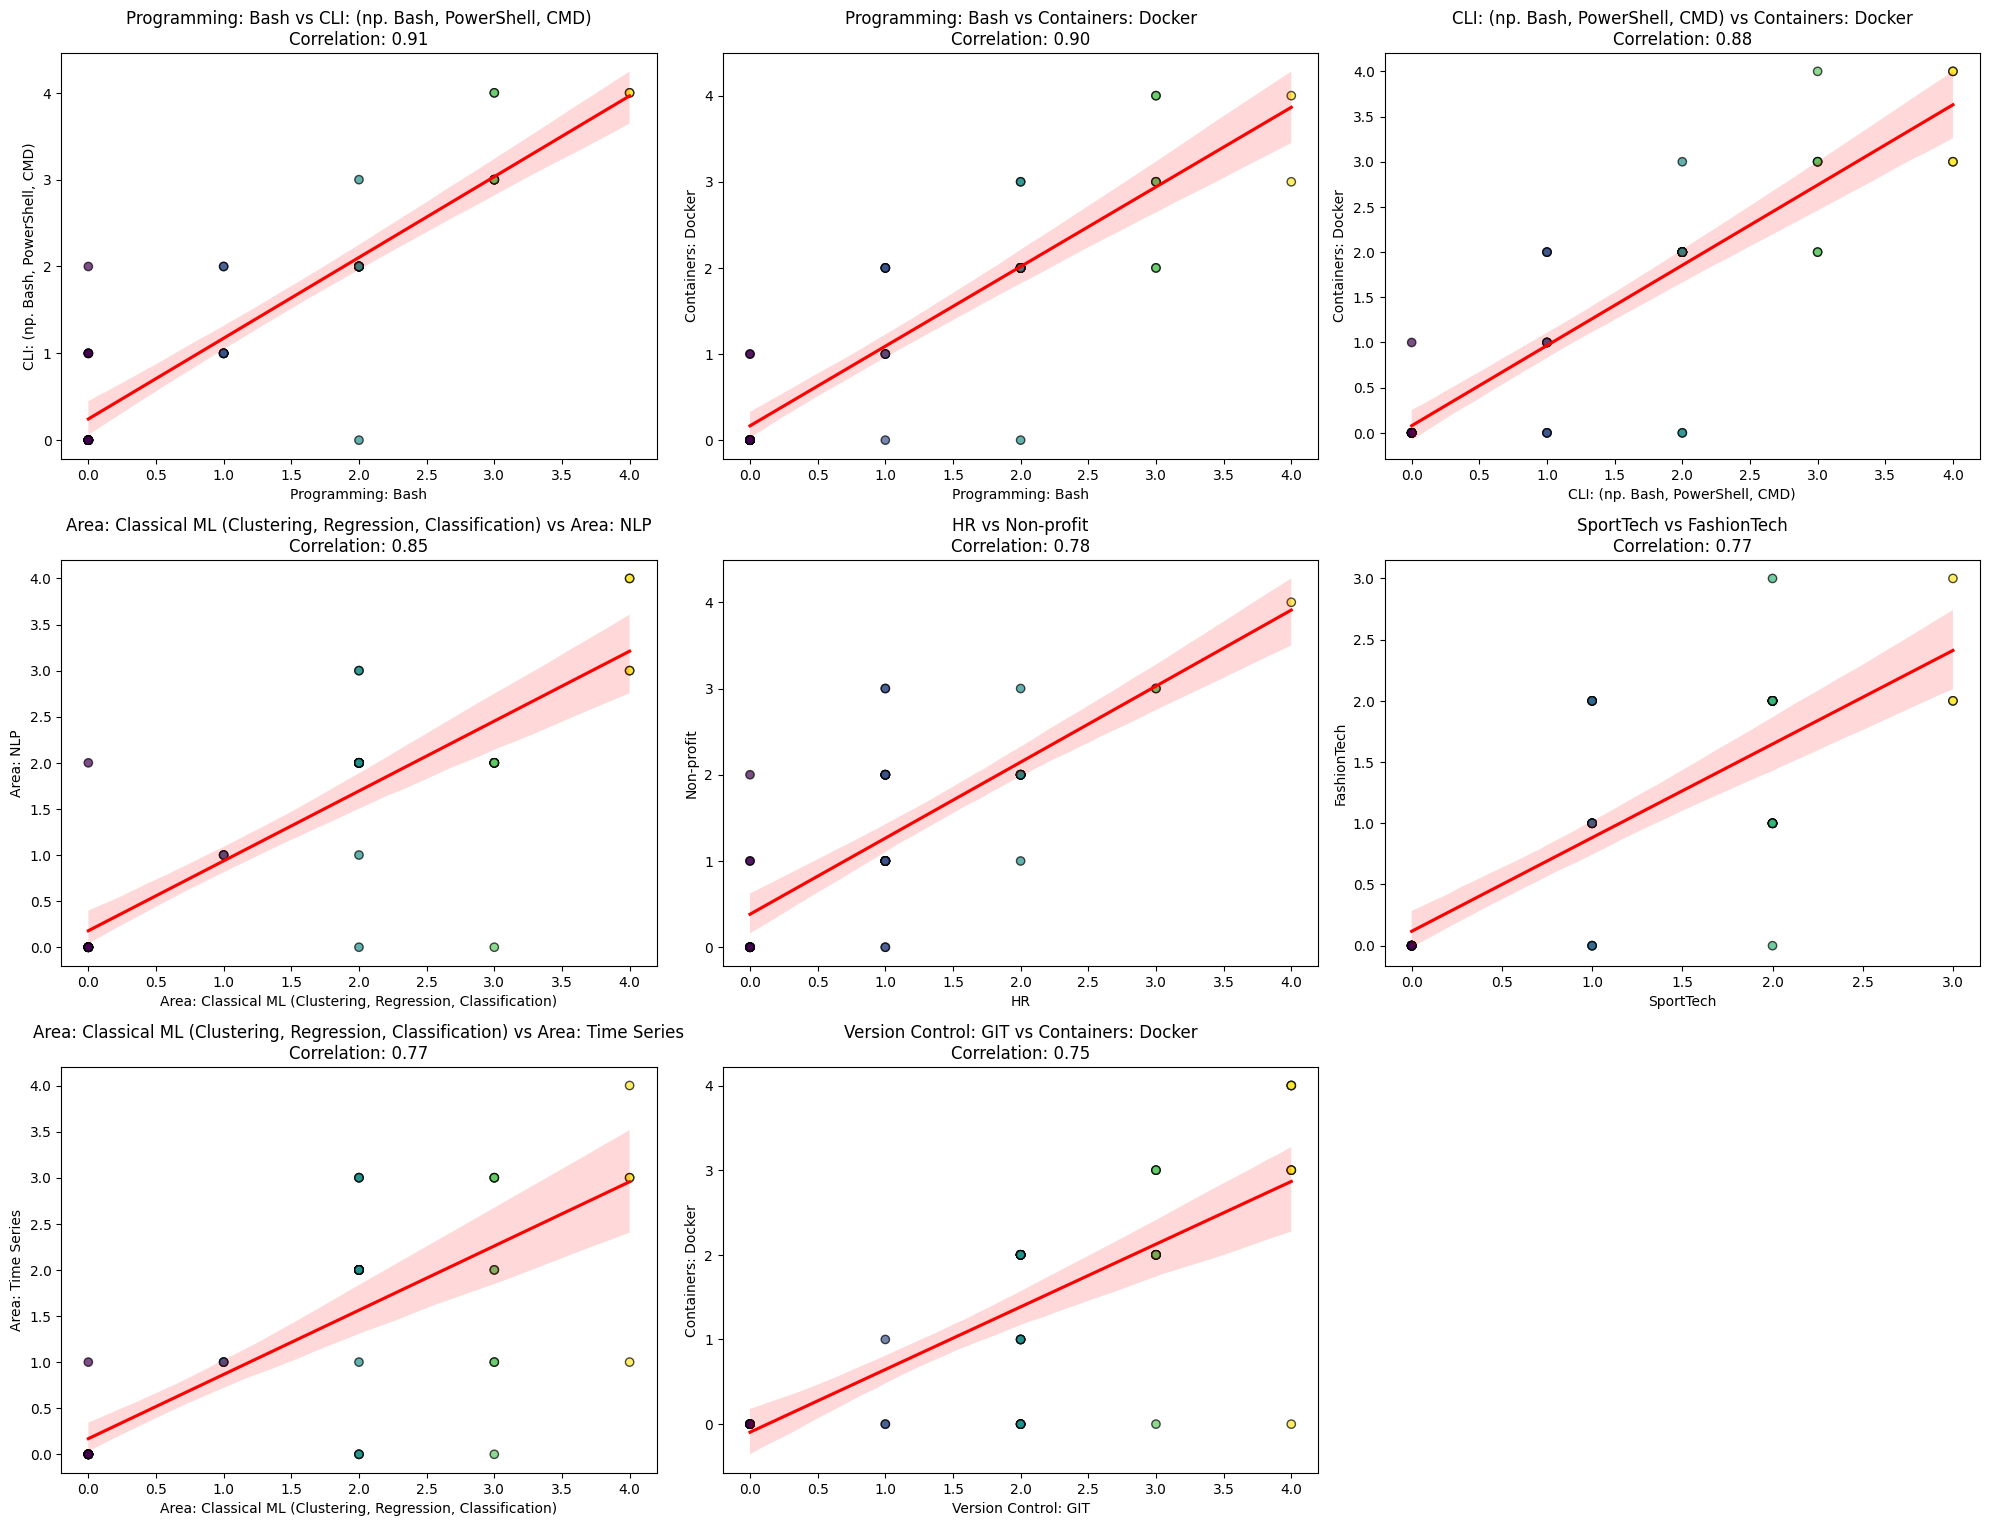

Programming: Bash                                            CLI: (np. Bash, PowerShell, CMD)    0.907887
                                                             Containers: Docker                  0.896332
CLI: (np. Bash, PowerShell, CMD)                             Containers: Docker                  0.882064
Area: Classical ML (Clustering, Regression, Classification)  Area: NLP                           0.850371
HR                                                           Non-profit                          0.778255
SportTech                                                    FashionTech                         0.774723
Area: Classical ML (Clustering, Regression, Classification)  Area: Time Series                   0.765360
Version Control: GIT                                         Containers: Docker                  0.753817
dtype: float64

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
# Ensure the dataset is loaded correctly
df = pd.read_csv(r'C:\Users\rejen\OneDrive\Documents\GitHub\ProjektAnalitiks\data\03_Processed\cleaned_data.csv')
 
# Define the numerical columns for correlation analysis
numeric_columns = ['Programming: R', 'Programming: Python', 'Programming: Bash', 
                   'Version Control: GIT', 'Containers: Docker', 'CLI: (np. Bash, PowerShell, CMD)', 
                   'Front End: (HTML, JavaScript, CSS)', 'Databases: SQL', 'Databases: NoSQL', 
                   'Cloud: AWS', 'Cloud: GPC', 'BI: PowerBI', 'BI: Tableau', 
                   'Area: Time Series', 'Area: Classical ML (Clustering, Regression, Classification)', 
                   'Area: NLP', 'Area: Computer Vision', 'Project Management', 'Promocja w Social Media', 
                   'Ux/Ui', 'Projektowanie graficzne', 'Nawiązywanie Relacji z Biznesem', 
                   'Nawiązywanie Relacji z naukowcami', 'Pozyskiwanie finansowania', 
                   'Współpraca z administracją UEW', 'FinTech', 'HealthTech', 'FashionTech', 
                   'E-commerce', 'SportTech', 'Non-profit', 'PropTech (nieruchomości)', 
                   'Cybersecurity', 'HR']
 
# Filter the dataset to include only the numerical columns
numeric_data = df[numeric_columns]
 
# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()
 
# Filter pairs with correlation greater than 0.75
high_corr_pairs_filtered_75 = correlation_matrix.unstack().sort_values(ascending=False)
high_corr_pairs_filtered_75 = high_corr_pairs_filtered_75[high_corr_pairs_filtered_75 < 1]  # Exclude self-correlation
high_corr_pairs_filtered_75 = high_corr_pairs_filtered_75[high_corr_pairs_filtered_75 > 0.75].drop_duplicates()
 
# Display the top 12 pairs with the new threshold
top_pairs_75 = high_corr_pairs_filtered_75.head(12)
 
# Plotting scatter plots with regression lines for filtered correlated pairs with the new threshold
plt.figure(figsize=(20, 20))
cmap = 'viridis'  # Define the colormap
 
for i, (pair, corr) in enumerate(top_pairs_75.items()):
    feature1, feature2 = pair
    plt.subplot(4, 3, i+1)
    plt.scatter(numeric_data[feature1], numeric_data[feature2], c=numeric_data[feature1], cmap=cmap, edgecolor='black', alpha=0.7)
    sns.regplot(x=numeric_data[feature1], y=numeric_data[feature2], scatter=False, color='red')
    plt.title(f'{feature1} vs {feature2}\nCorrelation: {corr:.2f}')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
plt.tight_layout()
plt.show()
 
# Displaying the top pairs
top_pairs_75

##### General observations:

- There is a strong link between **command-line proficiency** and other technical skills such as **Bash** scripting and **Docker**. This indicates that individuals comfortable with command-line interfaces are likely to engage deeply with other technical tools and automation processes.

- The correlation between areas like **Classical ML** and **NLP**, and **Time Series** analysis with **Classical ML**, suggests that individuals working in these fields often need a broad set of skills and would likely be involved in interdisciplinary projects.

- The correlations observed in sectors like **Non-profit** and **HR**, and **SportTech** and **FashionTech**, reflect specific industry trends where certain roles and technological advancements overlap significantly.

##### Here are the top 8 pairs displayed in the scatter plots:

- **CLI: (np. Bash, PowerShell, CMD)** and **Programming: Bash:** 0.91
  
Strong positive correlation. Users proficient in command-line interfaces are highly likely to have proficiency in Bash scripting.

- **Programming: Bash** and **Containers: Docker:** 0.9
  
Strong correlation between Bash scripting skills and Docker usage, indicating their frequent use together in automation and deployment.

- **CLI: (np. Bash, PowerShell, CMD)** and **Containers: Docker:** 0.88
  
High proficiency in command-line interfaces is strongly linked to Docker usage, reflecting the common use of command-line tools in managing Docker containers.

- **Area: Classical ML (Clustering, Regression, Classification)** and **Area: NLP:** 0.85
  
Significant overlap between classical machine learning techniques and NLP, suggesting that expertise in one often includes the other.

- **Non-profit** and **HR:** 0.78
  
Moderate to strong correlation, potentially indicating a high involvement of HR functions within non-profit organizations.

- **SportTech** and **FashionTech:** 0.77
  
Correlation suggests shared innovation trends and technological overlaps between the sports and fashion tech industries.

- **Area: Time Series** and **Area: Classical ML (Clustering, Regression, Classification):** 0.77
  
Indicates that time series analysis often employs methods from classical ML, showing a significant overlap in methodologies.

- **Version Control: GIT** and **Containers: Docker:** 0.75
  
Moderate to strong correlation, reflecting their essential roles in modern DevOps and CI/CD practices.

##### Let's utilize PCA analysis:

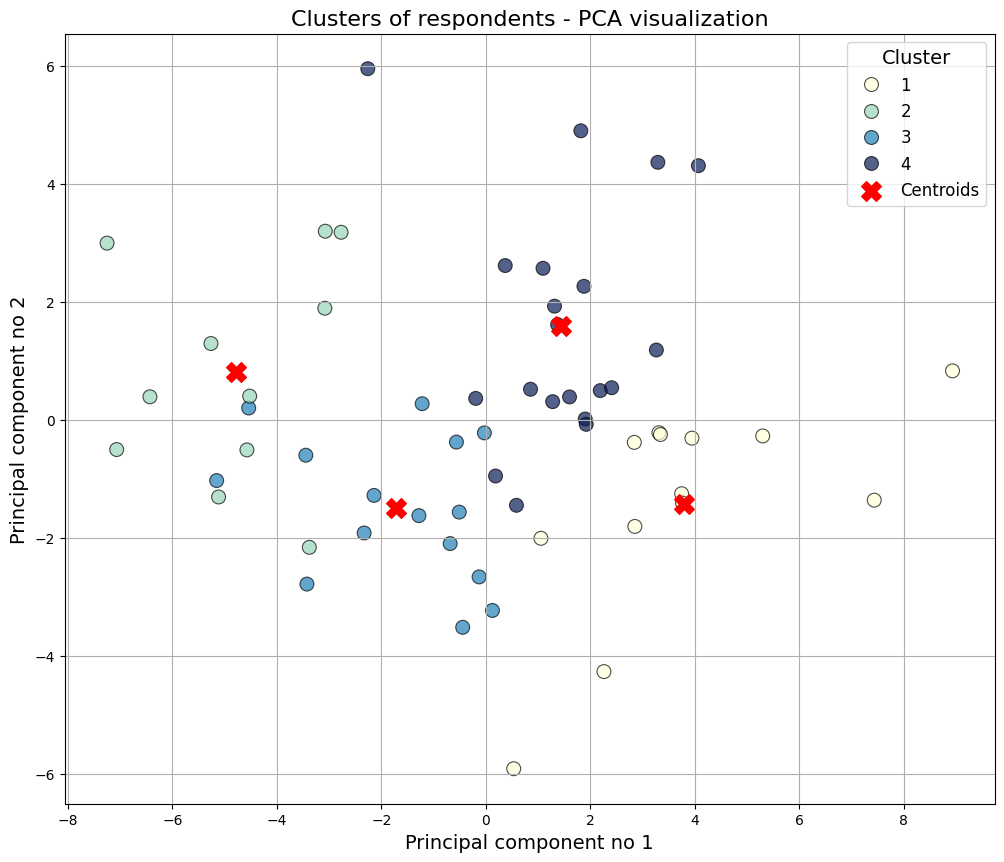

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Load the dataset
df = pd.read_csv(r'C:\Users\rejen\OneDrive\Documents\GitHub\ProjektAnalitiks\data\03_Processed\cleaned_data.csv')

# List of numerical columns
numerical_columns = ['Programming: R', 'Programming: Python', 'Programming: Bash', 
                     'Version Control: GIT', 'Containers: Docker', 'CLI: (np. Bash, PowerShell, CMD)', 
                     'Front End: (HTML, JavaScript, CSS)', 'Databases: SQL', 'Databases: NoSQL', 
                     'Cloud: Azure', 'Cloud: AWS', 'Cloud: GPC', 'BI: PowerBI', 'BI: Tableau', 
                     'Area: Time Series', 'Area: Classical ML (Clustering, Regression, Classification)', 
                     'Area: NLP', 'Area: Computer Vision', 'Project Management', 'Promocja w Social Media', 
                     'Ux/Ui', 'Projektowanie graficzne', 'Nawiązywanie Relacji z Biznesem', 
                     'Nawiązywanie Relacji z naukowcami', 'Pozyskiwanie finansowania', 
                     'Współpraca z administracją UEW', 'FinTech', 'HealthTech', 'FashionTech', 
                     'E-commerce', 'SportTech', 'Non-profit', 'PropTech (nieruchomości)', 
                     'Cybersecurity', 'HR']

# Standardize the numerical columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numerical_columns])

# Apply KMeans clustering with the optimal number of clusters (assuming 4 based on elbow method)
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_data)

# Adjust cluster labels to start from 1 instead of 0
df['Cluster'] += 1

# Apply PCA for dimensionality reduction to visualize the clusters
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
df['PCA1'] = principal_components[:, 0]
df['PCA2'] = principal_components[:, 1]

# Improved visualization of the clusters
plt.figure(figsize=(12, 10))
palette = sns.color_palette("YlGnBu", as_cmap=True)
scatter = sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette=palette, s=100, edgecolor='k', alpha=0.7)

# Add centroids of the clusters
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=200, c='red', label='Centroids', marker='X')

# Adding titles and labels
plt.title('Clusters of respondents - PCA visualization', fontsize=16)
plt.xlabel('Principal component no 1', fontsize=14)
plt.ylabel('Principal component no 2', fontsize=14)

# Enhancing the legend
plt.legend(title='Cluster', title_fontsize='14', fontsize='12', loc='best')
plt.grid(True)
plt.show()


**Cluster 0**: Respondents with a balanced set of skills and proficiencies across various areas.

**Cluster 1**: Contains respondents who may be beginners or have lower proficiency in many areas.

**Cluster 2**: Includes respondents who are highly proficient in certain areas or have specialized skills.

**Cluster 3**: Comprises respondents with a mix of moderate to high skills in various areas, similar to cluster 0 but with distinct differences

Centroids marked on the graph are centres of each cluster.

##### For better understading of distribution of skills amongst different clusters I will use violin plots.

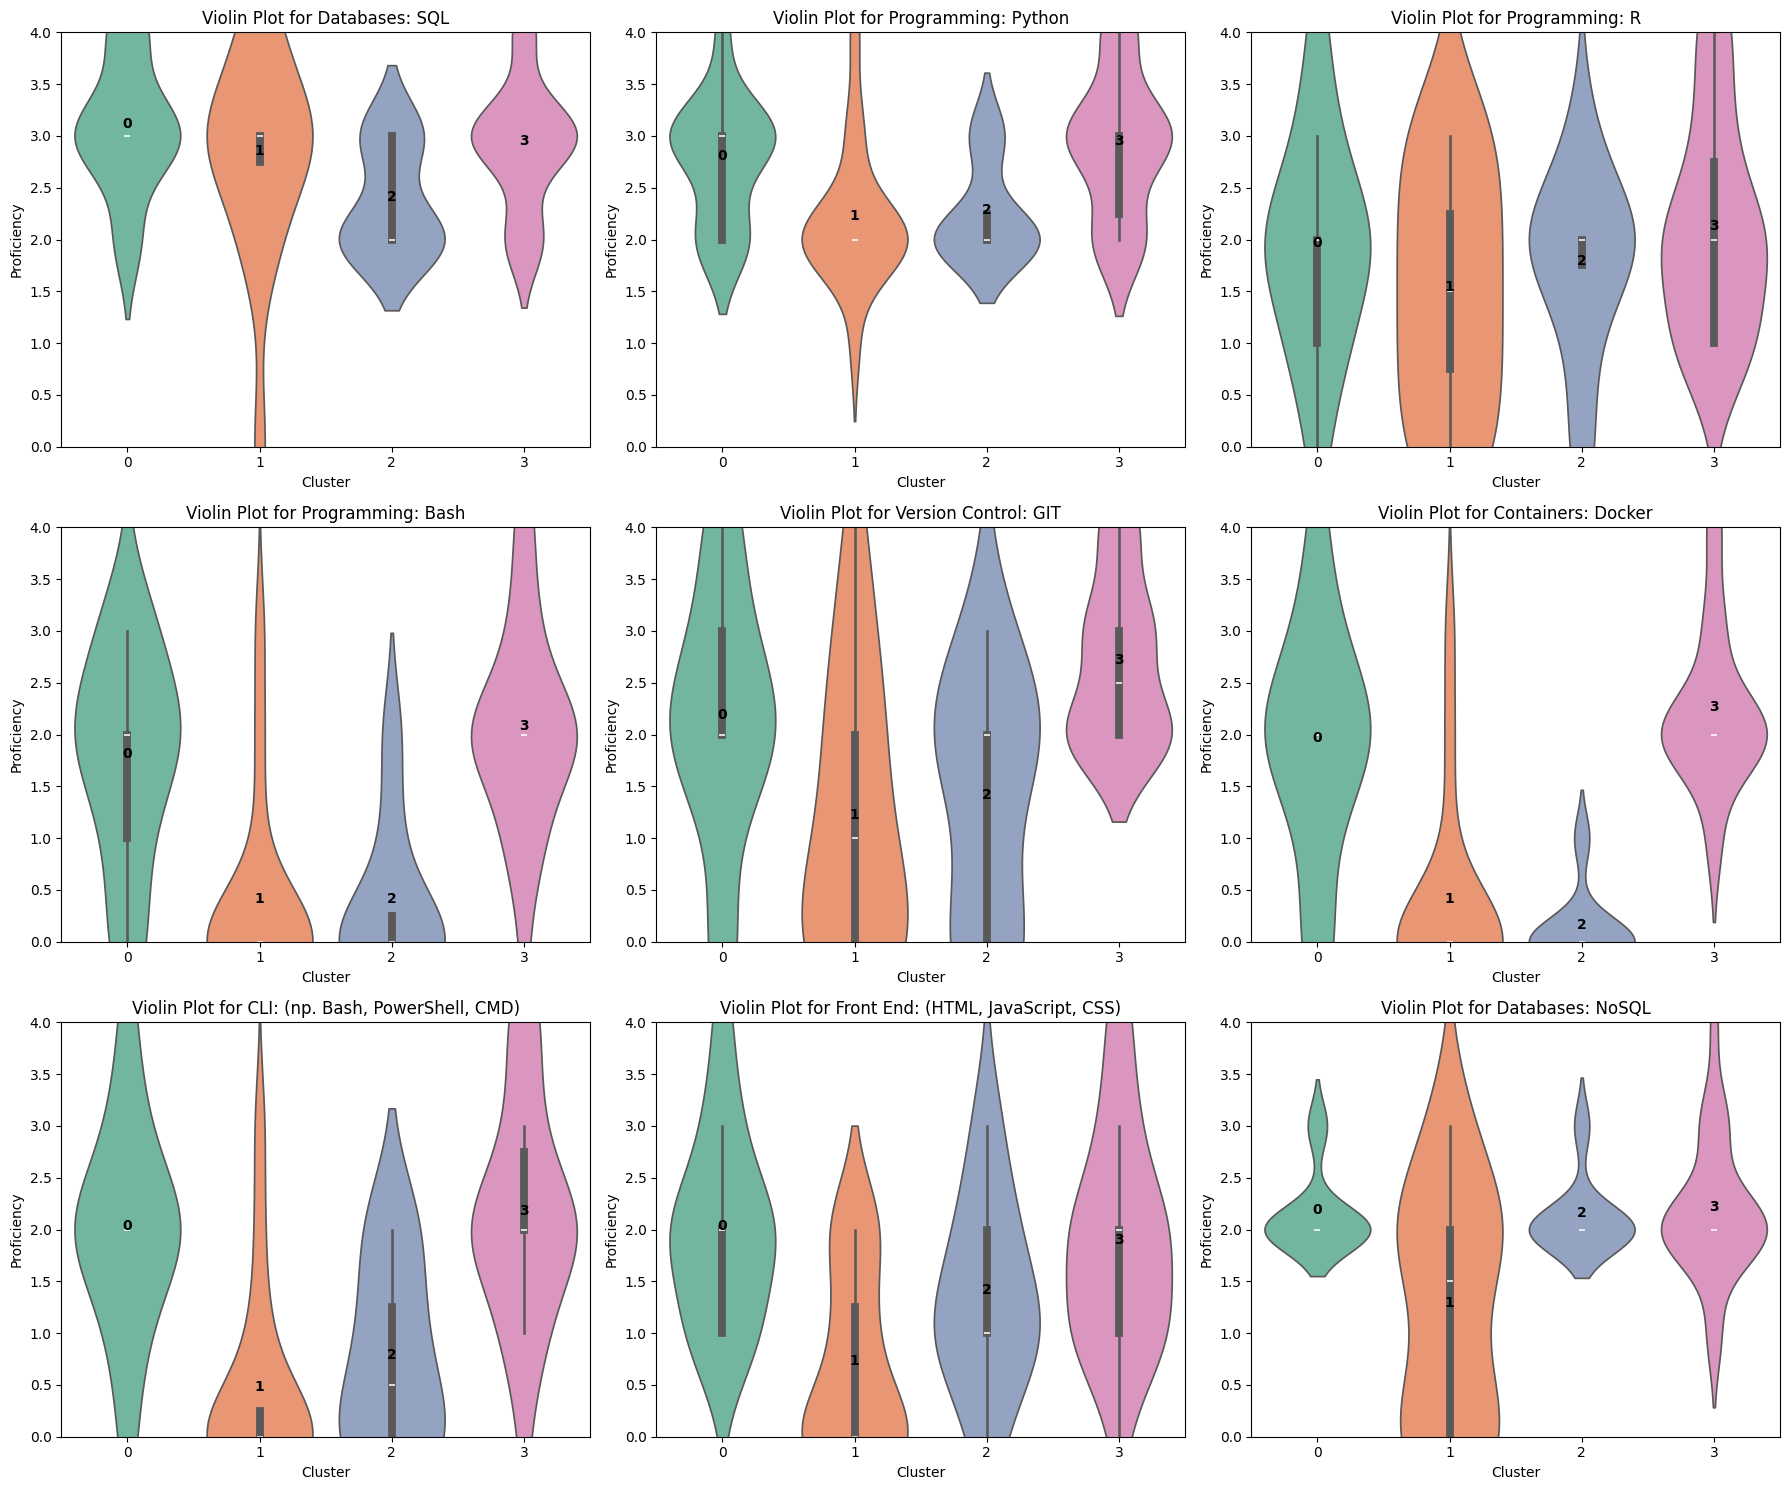

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load the dataset
df = pd.read_csv(r'C:\Users\rejen\OneDrive\Documents\GitHub\ProjektAnalitiks\data\03_Processed\cleaned_data.csv')

# Define the numerical columns for skill analysis
skill_columns = ['Programming: R', 'Programming: Python', 'Programming: Bash', 
                 'Version Control: GIT', 'Containers: Docker', 'CLI: (np. Bash, PowerShell, CMD)', 
                 'Front End: (HTML, JavaScript, CSS)', 'Databases: SQL', 'Databases: NoSQL', 
                 'Cloud: AWS', 'Cloud: GPC', 'BI: PowerBI', 'BI: Tableau', 
                 'Area: Time Series', 'Area: Classical ML (Clustering, Regression, Classification)', 
                 'Area: NLP', 'Area: Computer Vision', 'Project Management', 'Promocja w Social Media', 
                 'Ux/Ui', 'Projektowanie graficzne', 'Nawiązywanie Relacji z Biznesem', 
                 'Nawiązywanie Relacji z naukowcami', 'Pozyskiwanie finansowania', 
                 'Współpraca z administracją UEW', 'FinTech', 'HealthTech', 'FashionTech', 
                 'E-commerce', 'SportTech', 'Non-profit', 'PropTech (nieruchomości)', 
                 'Cybersecurity', 'HR']

# Standardize the numerical columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[skill_columns])

# Apply KMeans clustering with the optimal number of clusters (assuming 4 based on elbow method)
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_data)

# Identify the best skills from each cluster
best_skills = df.groupby('Cluster')[skill_columns].mean().idxmax(axis=1).unique()

# Prepare data for violin plots
melted_df = df.melt(id_vars=['Cluster'], value_vars=skill_columns, var_name='Skill', value_name='Proficiency')

# Combine the best skills with some additional unique skills, excluding 'Cloud: Azure'
additional_skills = [skill for skill in skill_columns if skill not in best_skills][:9 - len(best_skills)]  # Ensure we get 9 unique skills in total
selected_skills = list(best_skills) + additional_skills

# Define a custom color palette with 4 distinct colors
custom_palette = sns.color_palette("Set2", 4)  # Using 'Set2' for distinct colors

# Plot violin plots for the selected skills
plt.figure(figsize=(18, 15))
for i, skill in enumerate(selected_skills, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(x='Cluster', y='Proficiency', hue='Cluster', data=melted_df[melted_df['Skill'] == skill], palette=custom_palette, legend=False)
    plt.title(f'Violin Plot for {skill}')
    plt.xlabel('Cluster')
    plt.ylabel('Proficiency')
    plt.ylim(0, 4)  # Set y-axis limits from 0 to 4

    # Adding cluster labels inside the plot
    cluster_means = df.groupby('Cluster')[skill].mean()
    for cluster, mean in cluster_means.items():
        plt.text(cluster, mean, f'{cluster}', horizontalalignment='center', size='medium', color='black', weight='semibold')

plt.tight_layout()
plt.show()

**Cluster 0** consistently shows higher proficiency in a broader range of skills, indicating a well-rounded skill set among respondents.

**Cluster 1** also shows high proficiency in several key areas but is slightly less consistent compared to **Cluster 0**.

**Cluster 2** and **Cluster 3** generally show lower proficiency across most skills, suggesting that these respondents might be more specialized or less experienced in these areas.

The violin plots reveal the distribution of skills within each cluster, highlighting that even within a cluster, there can be significant variation in proficiency levels.
These insights can be useful for targeted interventions, such as:

Providing advanced training in specific skills for **Cluster 2** and **Cluster 3** to bring their proficiency levels up.
Encouraging knowledge sharing and mentorship from **Cluster 0** and **Cluster 1** to other clusters.
Identifying areas where the community as a whole might need additional resources or support.

Now let's create box plots for grouped skills.

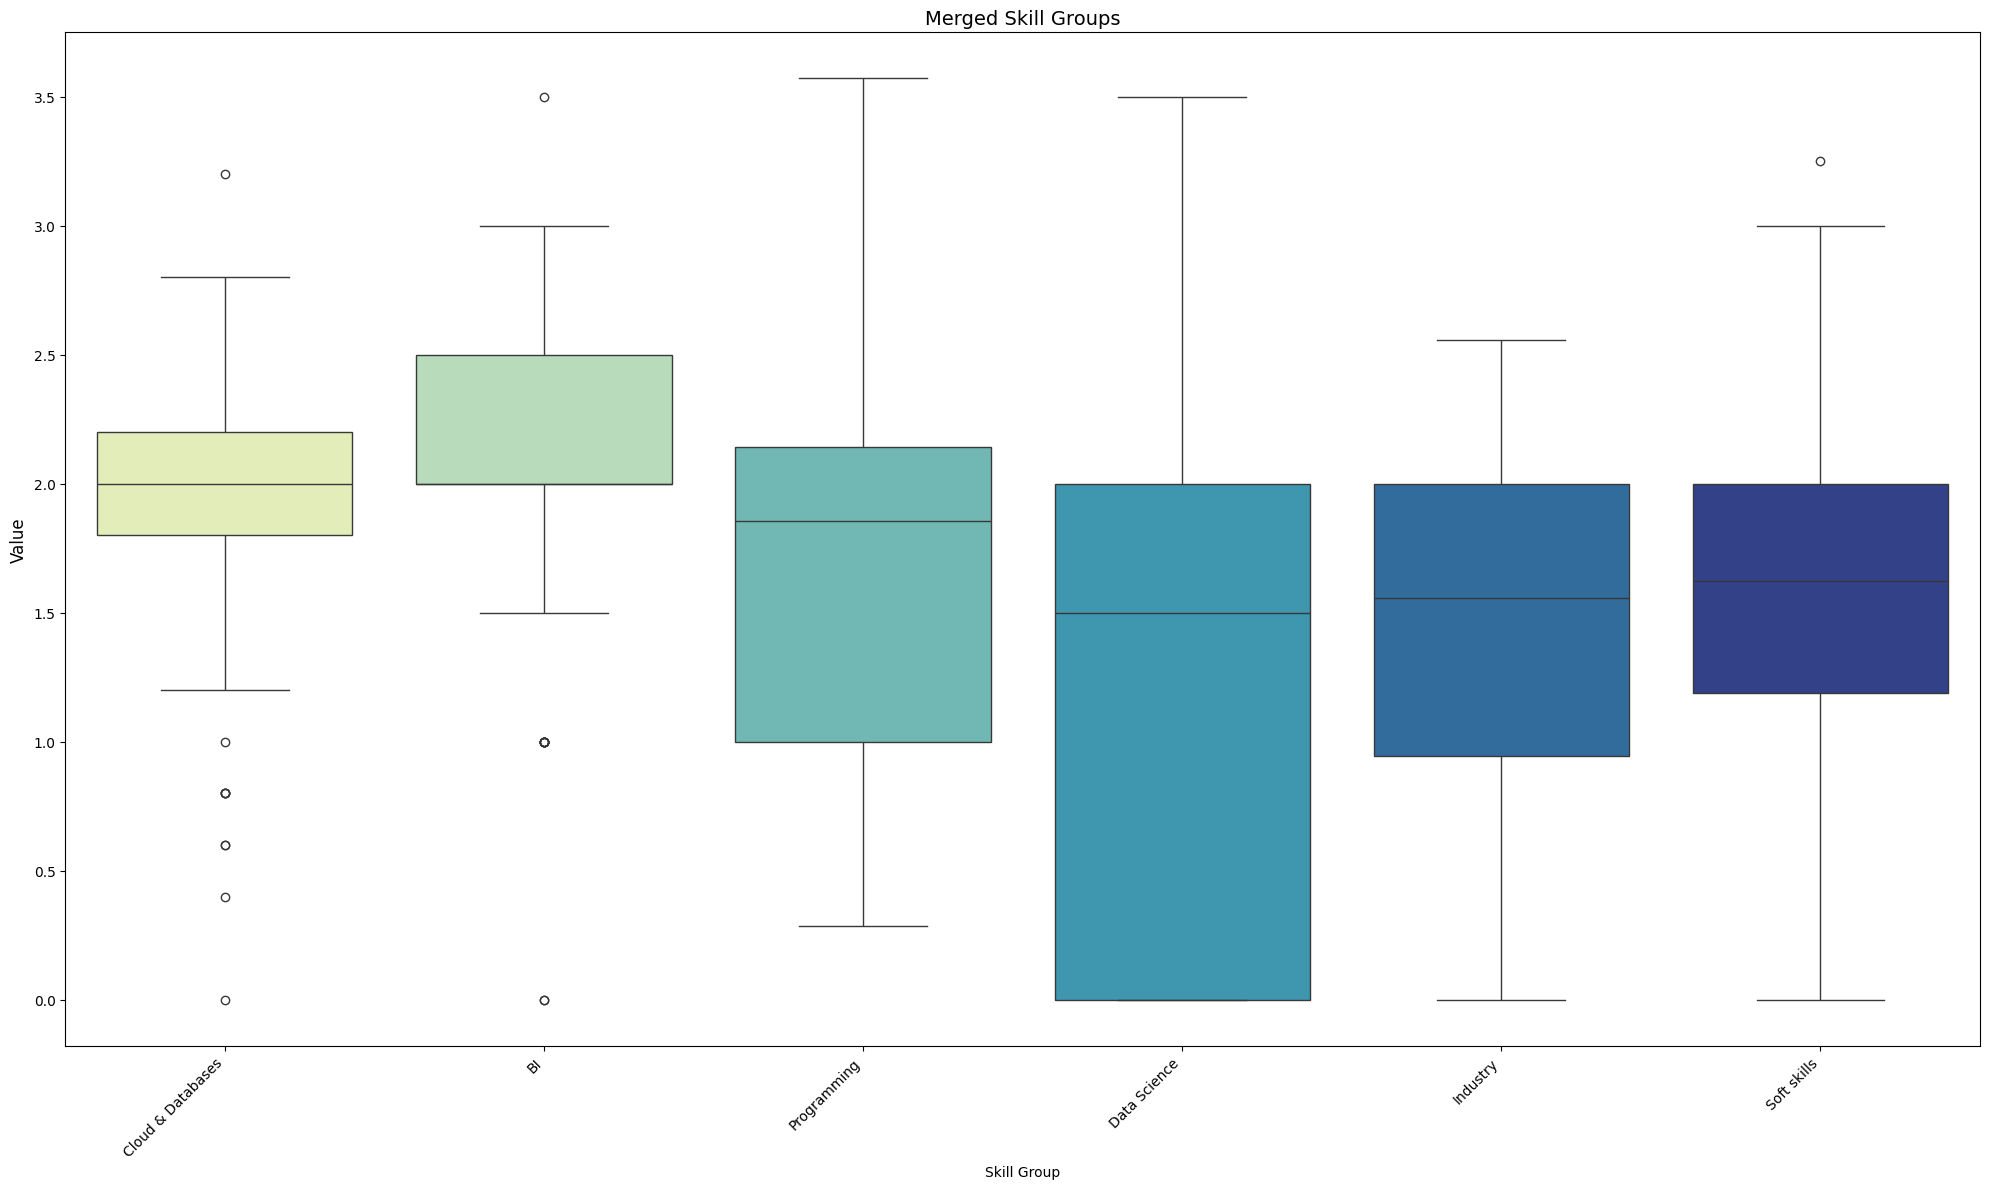

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Load the dataset
data = pd.read_csv(r'C:\Users\rejen\OneDrive\Documents\GitHub\ProjektAnalitiks\data\03_Processed\cleaned_data.csv')

# Identify numerical columns
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Define your groups and map columns to these groups
groups = {
    'Cloud & Databases': ['Cloud: AWS', 'Cloud: Azure', 'Cloud: GPC', 'Databases: NoSQL', 'Databases: SQL'],
    'BI': ['BI: PowerBI', 'BI: Tableau'],
    'Programming': ['Programming: R', 'Programming: Python', 'Programming: Bash', 'CLI: (np. Bash, PowerShell, CMD)', 'Version Control: GIT', 'Containers: Docker', 'Front End: (HTML, JavaScript, CSS)'],
    'Data Science': ['Area: Time Series', 'Area: Classical ML (Clustering, Regression, Classification)', 'Area: NLP', 'Area: Computer Vision'],
    'Industry': ['FinTech', 'HealthTech', 'FashionTech', 'E-commerce', 'SportTech', 'Non-profit', 'PropTech (nieruchomości)', 'Cybersecurity', 'HR'],
    'Soft skills': ['Project Management','Promocja w Social Media','Ux/Ui','Projektowanie graficzne','Nawiązywanie Relacji z Biznesem','Nawiązywanie Relacji z naukowcami','Pozyskiwanie finansowania','Współpraca z administracją UEW']
}

# Generate a gradient color map
colors = sns.color_palette("YlGnBu", len(groups))
group_colors = dict(zip(groups.keys(), colors))

# Create a new DataFrame to hold group-wise data for plotting
grouped_data = []
for group, columns in groups.items():
    group_values = data[columns].mean(axis=1)  # Combine values by taking the mean
    temp_df = pd.DataFrame({group: group_values})
    temp_df['Group'] = group
    grouped_data.append(temp_df)

# Concatenate all the dataframes
grouped_df = pd.concat(grouped_data)

# Melt the dataframe for easier plotting with seaborn
melted_df = pd.melt(grouped_df, id_vars=['Group'], var_name='Skill', value_name='Value')

# Plotting box plots for each group with gradient colors
plt.figure(figsize=(20, 12))
sns.boxplot(x='Skill', y='Value', data=melted_df, hue='Skill', palette=group_colors, dodge=False)
plt.title('Merged Skill Groups', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Skill Group')
plt.ylabel('Value', fontsize=12)
plt.legend([],[], frameon=False)  # Remove the legend
plt.tight_layout()
plt.show()

Now let's compare competencies amongst all individuals:

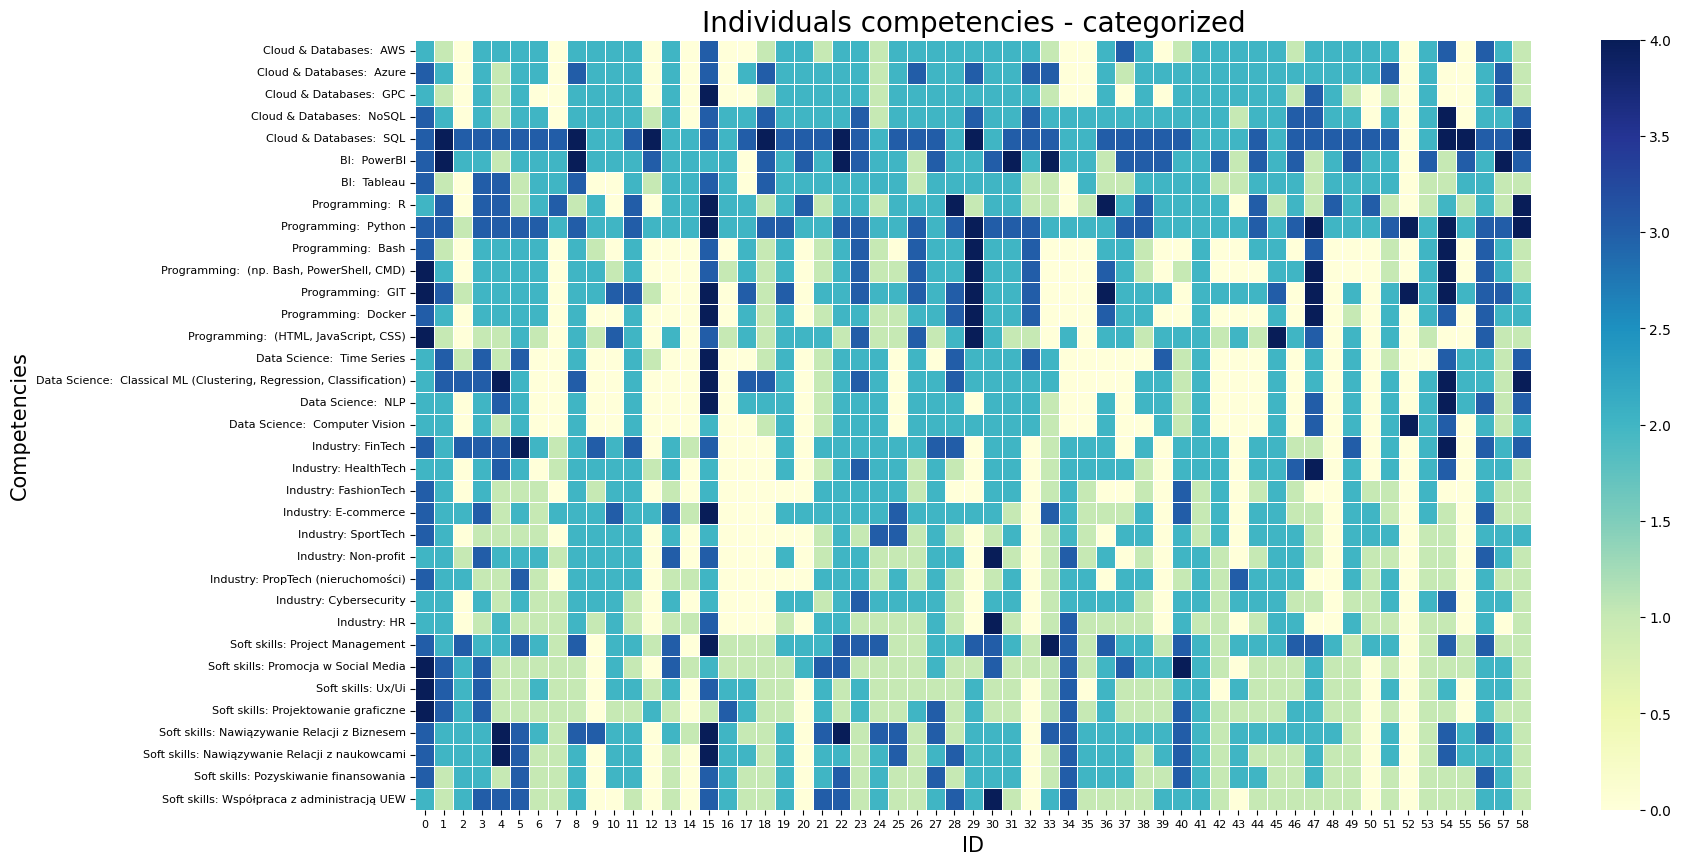

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv(r'C:\Users\rejen\OneDrive\Documents\GitHub\ProjektAnalitiks\data\03_Processed\cleaned_data.csv')

# Define the updated categories with original names for columns
categories_updated = {
    'Cloud & Databases': ['Cloud: AWS', 'Cloud: Azure', 'Cloud: GPC', 'Databases: NoSQL', 'Databases: SQL'],
    'BI': ['BI: PowerBI', 'BI: Tableau'],
    'Programming': ['Programming: R', 'Programming: Python', 'Programming: Bash', 'CLI: (np. Bash, PowerShell, CMD)', 'Version Control: GIT', 'Containers: Docker', 'Front End: (HTML, JavaScript, CSS)'],
    'Data Science': ['Area: Time Series', 'Area: Classical ML (Clustering, Regression, Classification)', 'Area: NLP', 'Area: Computer Vision'],
    'Industry': ['FinTech', 'HealthTech', 'FashionTech', 'E-commerce', 'SportTech', 'Non-profit', 'PropTech (nieruchomości)', 'Cybersecurity', 'HR'],
    'Soft skills': ['Project Management','Promocja w Social Media','Ux/Ui','Projektowanie graficzne','Nawiązywanie Relacji z Biznesem','Nawiązywanie Relacji z naukowcami','Pozyskiwanie finansowania','Współpraca z administracją UEW']
}

# Ensure all columns in the categories are present in the data
selected_columns = [col for sublist in categories_updated.values() for col in sublist if col in data.columns]

# Select only the columns that fall into the defined categories
heatmap_data_filtered = data[selected_columns]

# Generate a new mapping for column names with category as prefix
column_category_mapping = {}
for category, columns in categories_updated.items():
    for column in columns:
        if column in data.columns:
            column_category_mapping[column] = f"{category}: {column.split(':')[-1]}"

# Rename columns with new category mapping
heatmap_data_renamed = heatmap_data_filtered.rename(columns=column_category_mapping)

# Generate the heatmap with new column names
plt.figure(figsize=(18, 10))
sns.heatmap(heatmap_data_renamed.T, cmap='YlGnBu', cbar=True, annot=False, fmt="d", linewidths=.5, vmin=0, vmax=4)

plt.title('Individuals competencies - categorized', fontsize=20)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('ID', fontsize=15)
plt.ylabel('Competencies', fontsize=15)
plt.show()


Heatmap generated above is a great starting point for further drill down and a posibility to check which individuals can be grouped together based on their skillsets.

Now let's split the heatmap based on categories.

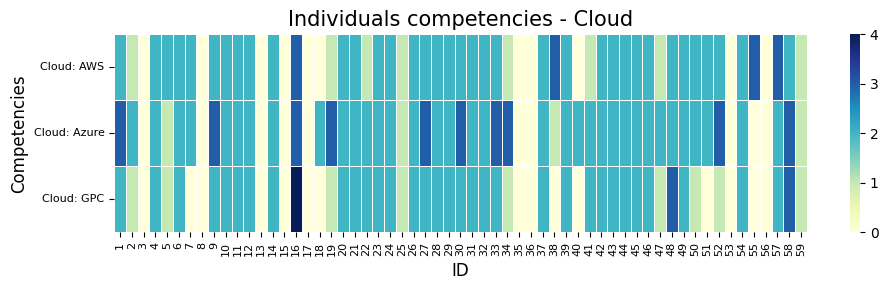

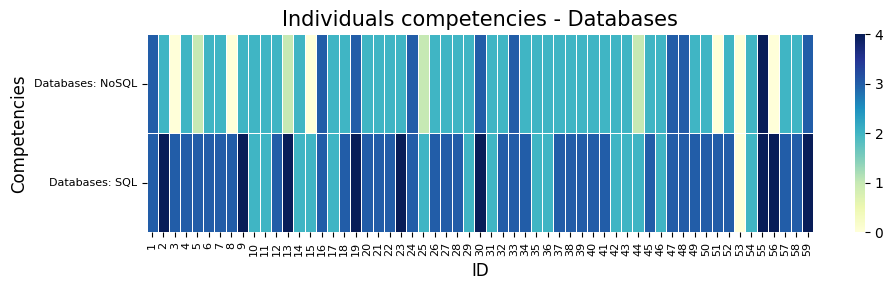

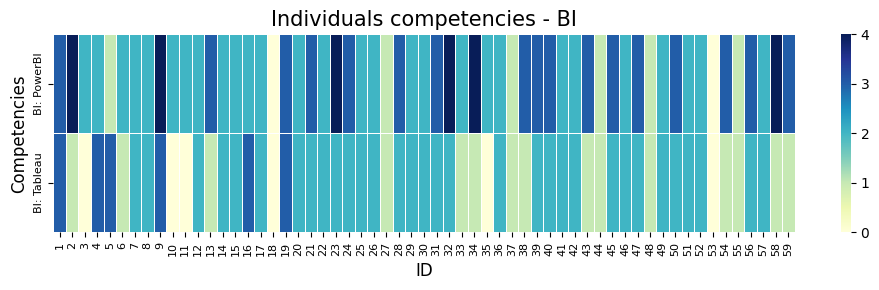

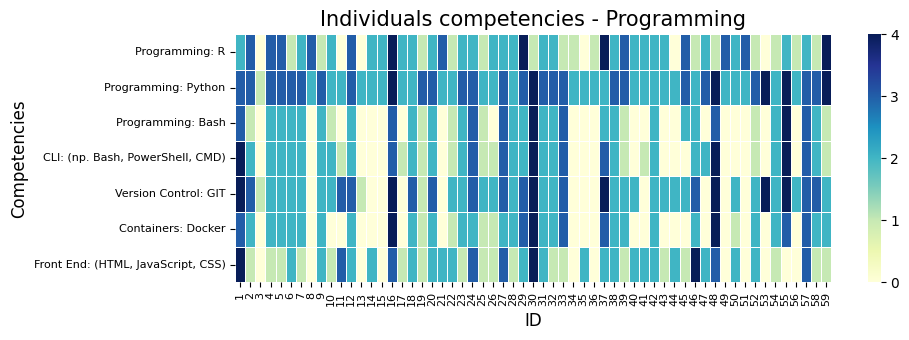

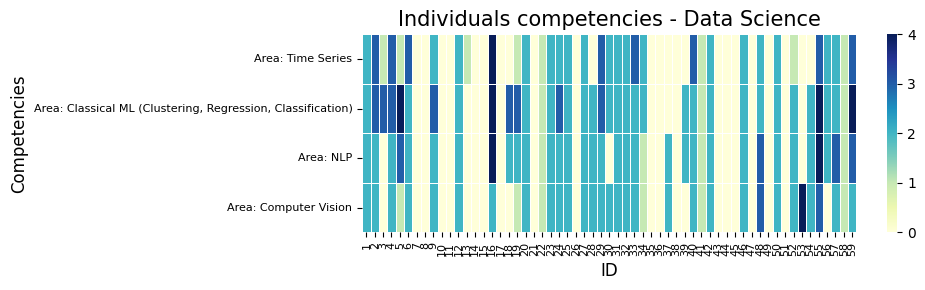

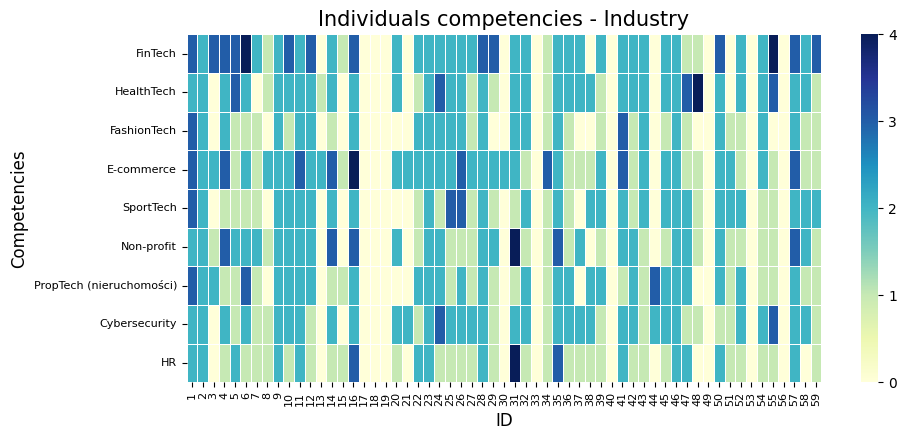

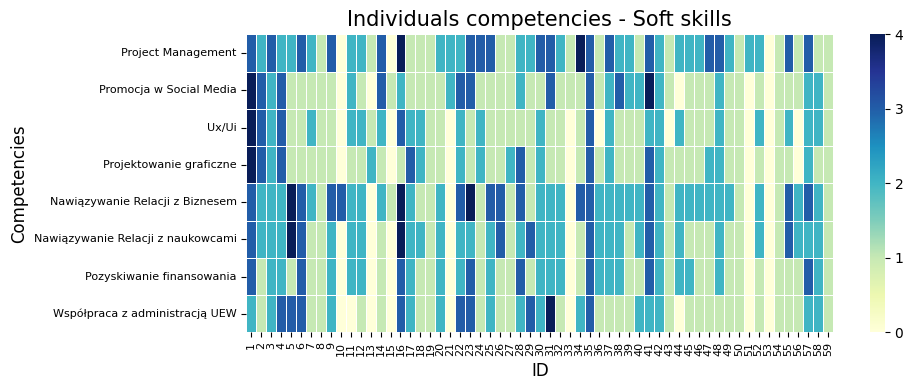

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the updated categories with original names for columns
categories_updated = {
    'Cloud': ['Cloud: AWS', 'Cloud: Azure', 'Cloud: GPC'],
    'Databases': ['Databases: NoSQL', 'Databases: SQL'],
    'BI': ['BI: PowerBI', 'BI: Tableau'],
    'Programming': ['Programming: R', 'Programming: Python', 'Programming: Bash', 'CLI: (np. Bash, PowerShell, CMD)', 'Version Control: GIT', 'Containers: Docker', 'Front End: (HTML, JavaScript, CSS)'],
    'Data Science': ['Area: Time Series', 'Area: Classical ML (Clustering, Regression, Classification)', 'Area: NLP', 'Area: Computer Vision'],
    'Industry': ['FinTech', 'HealthTech', 'FashionTech', 'E-commerce', 'SportTech', 'Non-profit', 'PropTech (nieruchomości)', 'Cybersecurity', 'HR'],
    'Soft skills': ['Project Management','Promocja w Social Media','Ux/Ui','Projektowanie graficzne','Nawiązywanie Relacji z Biznesem','Nawiązywanie Relacji z naukowcami','Pozyskiwanie finansowania','Współpraca z administracją UEW']
}

# Assuming 'data' is already defined and contains the necessary columns
selected_columns = [col for sublist in categories_updated.values() for col in sublist if col in data.columns]

# Select only the columns that fall into the defined categories
heatmap_data_filtered = data[selected_columns]

# Generate heatmaps for each category
def plot_heatmap(data, category_name, columns):
    height = max(len(columns) * 0.5, 3)  # Dynamically adjust height, with a minimum height of 3
    plt.figure(figsize=(10, height))
    ax = sns.heatmap(data[columns].T, cmap='YlGnBu', cbar=True, annot=False, fmt="d", linewidths=.5, vmin=0, vmax=4)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 1, 2, 3, 4])
    cbar.set_ticklabels([0, 1, 2, 3, 4])
    plt.title(f'Individuals competencies - {category_name}', fontsize=15)
    ax.set_xticks([x + 0.5 for x in range(len(data))])  # Place ticks in the middle of each bar
    ax.set_xticklabels(data.index + 1)  # Assuming IDs are in sequential order
    plt.xticks(fontsize=8, rotation=90)
    plt.yticks(fontsize=8)
    plt.xlabel('ID', fontsize=12)
    plt.ylabel('Competencies', fontsize=12)
    plt.tight_layout()  # Ensures everything fits within the figure
    plt.show()

for category, columns in categories_updated.items():
    plot_heatmap(heatmap_data_filtered, category, columns)

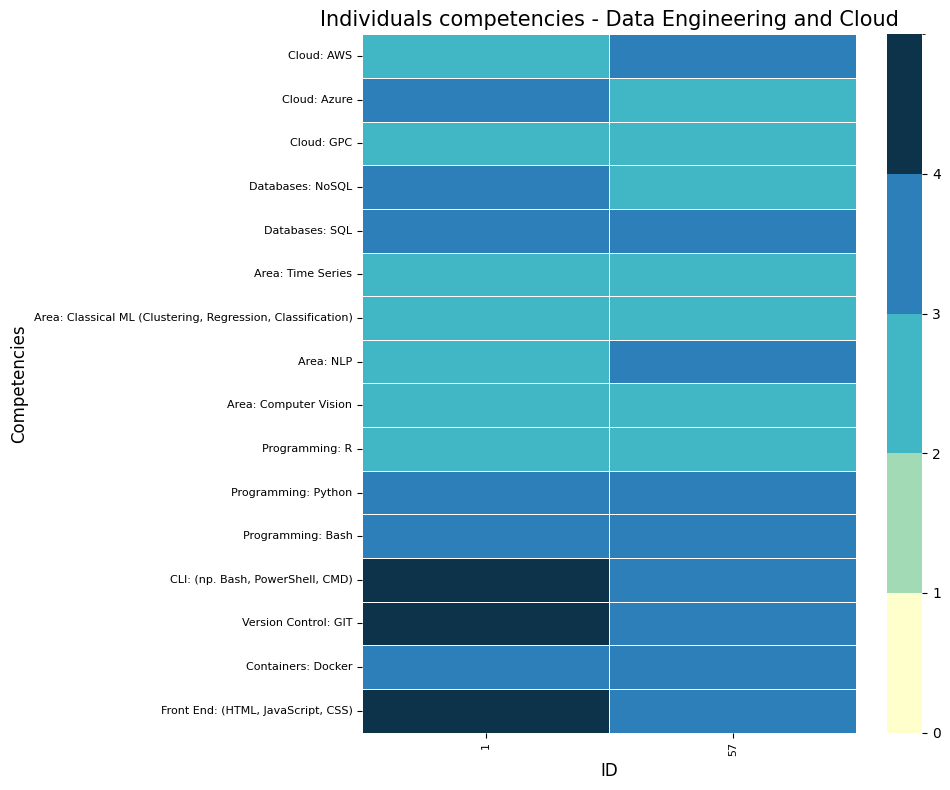

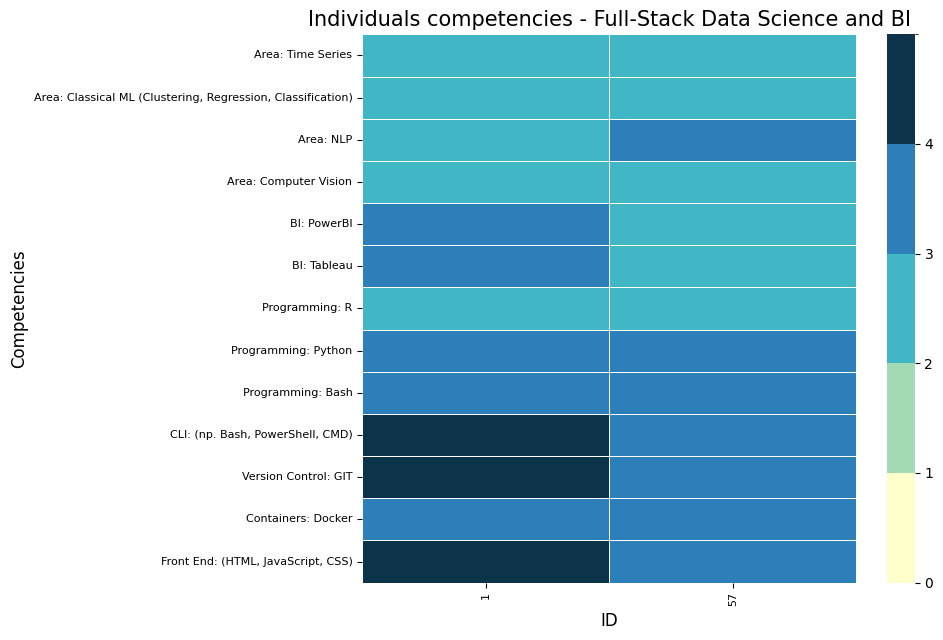

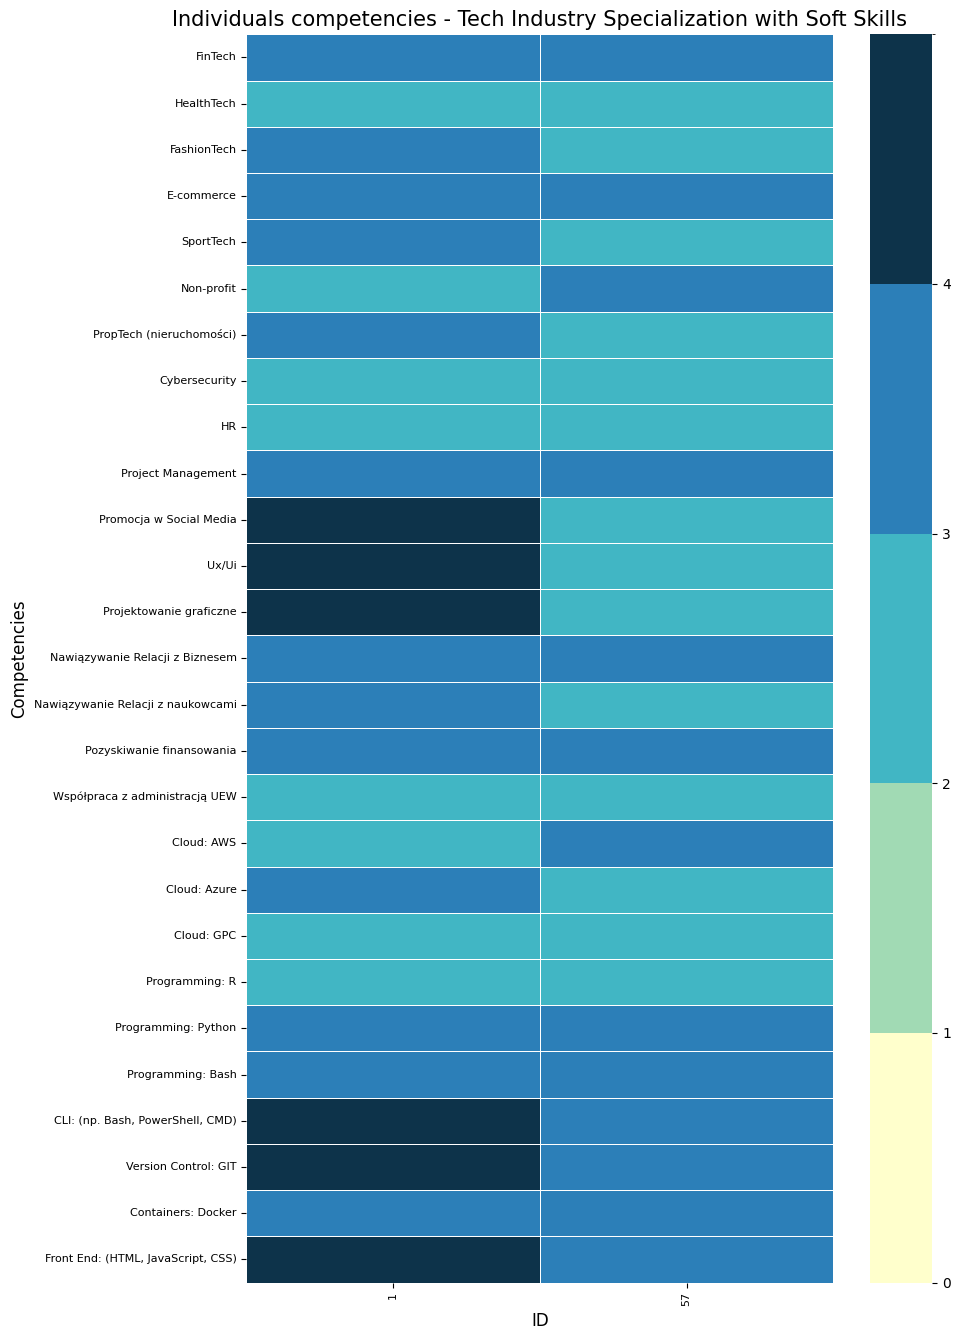

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define the updated categories with original names for columns
categories_updated = {
    'Cloud': ['Cloud: AWS', 'Cloud: Azure', 'Cloud: GPC'],
    'Databases': ['Databases: NoSQL', 'Databases: SQL'],
    'BI': ['BI: PowerBI', 'BI: Tableau'],
    'Programming': ['Programming: R', 'Programming: Python', 'Programming: Bash', 'CLI: (np. Bash, PowerShell, CMD)', 'Version Control: GIT', 'Containers: Docker', 'Front End: (HTML, JavaScript, CSS)'],
    'Data Science': ['Area: Time Series', 'Area: Classical ML (Clustering, Regression, Classification)', 'Area: NLP', 'Area: Computer Vision'],
    'Industry': ['FinTech', 'HealthTech', 'FashionTech', 'E-commerce', 'SportTech', 'Non-profit', 'PropTech (nieruchomości)', 'Cybersecurity', 'HR'],
    'Soft skills': ['Project Management','Promocja w Social Media','Ux/Ui','Projektowanie graficzne','Nawiązywanie Relacji z Biznesem','Nawiązywanie Relacji z naukowcami','Pozyskiwanie finansowania','Współpraca z administracją UEW']
}

# Custom color map for Yellow-Green-Blue scale with darker 4.0
cmap = ListedColormap(['#ffffcc', '#a1dab4', '#41b6c4', '#2c7fb8', '#0d334a'])
bounds = [0, 1, 2, 3, 4, 5]
norm = BoundaryNorm(bounds, cmap.N)

# Assuming 'data' is your DataFrame
# Ensure all columns in the categories are present in the data
selected_columns = [col for sublist in categories_updated.values() for col in sublist if col in data.columns]

# Select only the columns that fall into the defined categories
heatmap_data_filtered = data[selected_columns]

# Filter out rows where any column in the specified groups has a value of 0.0 or 1.0
for category, columns in categories_updated.items():
    if any(col in heatmap_data_filtered.columns for col in columns):
        mask = (heatmap_data_filtered[columns] == 0.0) | (heatmap_data_filtered[columns] == 1.0)
        rows_to_exclude = mask.any(axis=1)
        heatmap_data_filtered = heatmap_data_filtered[~rows_to_exclude]

# Combine categories for each strong group
strong_groups = {
    'Data Engineering and Cloud': categories_updated['Cloud'] + categories_updated['Databases'] + categories_updated['Data Science'] + categories_updated['Programming'],
    'Full-Stack Data Science and BI': categories_updated['Data Science'] + categories_updated['BI'] + categories_updated['Programming'],
    'Tech Industry Specialization with Soft Skills': categories_updated['Industry'] + categories_updated['Soft skills'] + categories_updated['Cloud'] + categories_updated['Programming']
}

# Generate heatmaps for each strong group
def plot_heatmap(data, group_name, columns, cmap, norm):
    height = max(len(columns) * 0.5, 3)  # Dynamically adjust height, with a minimum height of 3
    plt.figure(figsize=(10, height))
    ax = sns.heatmap(data[columns].T, cmap=cmap, norm=norm, cbar=True, annot=False, fmt="d", linewidths=.5)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 1, 2, 3, 4])
    cbar.set_ticklabels([0, 1, 2, 3, 4])
    plt.title(f'Individuals competencies - {group_name}', fontsize=15)
    ax.set_xticks([x + 0.5 for x in range(len(data))])  # Place ticks in the middle of each bar
    ax.set_xticklabels(data.index + 1)  # Assuming IDs are in sequential order
    plt.xticks(fontsize=8, rotation=90)
    plt.yticks(fontsize=8)
    plt.xlabel('ID', fontsize=12)
    plt.ylabel('Competencies', fontsize=12)
    plt.tight_layout()  # Ensures everything fits within the figure
    plt.show()

for group_name, columns in strong_groups.items():
    plot_heatmap(heatmap_data_filtered, group_name, columns, cmap, norm)

## **Conclusion**

Data cleaning has made significant changes to the dataset, leaving only rows and columns with non-missing values to ensure quality presentation of data on further stages.

In chapter "**Exploratory Data Analysis**" we performed a series of basic, as well as advanced data exploration and visualization techniques. After each analysis there is a visualization and simple summary to present insights that were collected.

EDA section covered some of the most useful techniques for data visualisation, such as: **heatmap** (for visualising correlation and missing values), simple **bar charts** and **column charts**, **box-plots**, **scatter plots**, **violin plots**, **stacked column plots**, **line plots** or **dendrogram**. 

It also covered some basic forms of scientific approach to data in forms of: **clustering**, **outlier detection**, **data imputation**, **PCA** and **regression analysis**.



Based on the results presented above, there is a general consensus that the surveyed team consists of well-skilled individuals - especially in technical fields of programming, data science, cloud and business intelligence.